In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from collections import defaultdict
from pathlib import Path
from typing import Dict

plt.style.use("ggplot")
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
def sample_name(s: str) -> str:
    for sfx in ["_rep1", "_rep2", "-singleplex", "-multiplex"]:
        s = s.replace(sfx, "")
    return s

In [3]:
with open("../../docs/final_samples.csv") as fp:
    final_samples = set(fp.read().splitlines()) 

In [4]:
len(final_samples)

72

In [5]:
smear_df = pd.read_csv("../../docs/smear_results.csv", index_col="sample")
ont_df = pd.read_csv("../../docs/ont_samples.csv", index_col="sample")

In [6]:
ont_comp_df = pd.read_html("../../results/report/nanopore_composition.html")
assert len(ont_comp_df) == 1
ont_comp_df = ont_comp_df[0]
ont_comp_df.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in ont_comp_df.columns]
ont_comp_df["source"] = "sputum"
ont_comp_df["technology"] = "nanopore"
ont_comp_df["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in ont_comp_df["sample"]]
ont_comp_df["is_multiplex"] = [not pd.isna(ont_df.at[s, "barcode_kit"]) for s in  ont_comp_df["sample"]]
#ont_comp_df

In [7]:
illumina_df1 = pd.read_html("../../results/report/illumina_culture_composition.html")
assert len(illumina_df1) == 1
illumina_df1 = illumina_df1[0]
illumina_df1.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in illumina_df1.columns]
illumina_df1["source"] = "culture"
illumina_df1["technology"] = "illumina"
illumina_df1["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in illumina_df1["sample"]]
# illumina_df1

In [8]:
illumina_df2 = pd.read_html("../../results/report/illumina_sputum_composition.html")
assert len(illumina_df2) == 1
illumina_df2 = illumina_df2[0]
illumina_df2.columns = [t[1] if t[0].startswith("Unnam") else t[0] for t in illumina_df2.columns]
illumina_df2["source"] = "sputum"
illumina_df2["technology"] = "illumina"
illumina_df2["smear"] = [smear_df.at[sample_name(s), "smear_result"] for s in illumina_df2["sample"]]
# illumina_df2

In [9]:
comp_df = pd.concat([ont_comp_df, illumina_df1, illumina_df2])
comp_df.reset_index(inplace=True)
# remove replicates
comp_df = comp_df.loc[~comp_df["sample"].str.contains("_rep")]
comp_df["sample"] = [s.split("-s")[0].split("-m")[0] for s in comp_df["sample"]]
comp_df["is_multiplex"].fillna(False, inplace=True)
comp_df

,index,sample,keep,keep%,contam,contam%,unmapped,unmapped%,total,coverage,lineage,species,source,technology,smear,is_multiplex
0,0,P201,895,0.11%,644877,77.08%,190847,22.81%,836619,0.2,Unknown,Mycobacterium_tuberculosis,sputum,nanopore,+,True
1,1,P202,24865,1.83%,1153816,85.11%,176981,13.05%,1355662,6.0,1.1.2,Mycobacterium_tuberculosis,sputum,nanopore,+,True
2,2,P203,3768,0.46%,783301,95.23%,35497,4.32%,822566,1.1,Unknown,Mycobacterium_tuberculosis,sputum,nanopore,+,True
3,3,P203,19938,0.45%,4257677,96.47%,136039,3.08%,4413654,6.6,4.1.2,Mycobacterium_tuberculosis,sputum,nanopore,+,False
4,4,P204,414,0.07%,57693,10.05%,515903,89.88%,574010,0.1,Unknown,Unknown,sputum,nanopore,+,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,85,Test_NC2,7555,0.37%,1977115,96.53%,63620,3.11%,2048290,0.5,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False
231,86,Test_NC3,22874,1.04%,2080051,94.85%,89957,4.10%,2192882,1.5,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False
232,87,Test_NC4,14074,1.00%,1316174,93.65%,75229,5.35%,1405477,0.9,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False
233,88,Test_NC5,28061,1.61%,1554571,88.97%,164633,9.42%,1747265,1.9,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False


In [10]:
comp_df = comp_df.query("sample in @final_samples")

Firstly, let's take a look at how many of the Nanopore-sequenced samples were sequenced on Illumina (sputum and culture)

In [11]:
ont_samples = {sample_name(s) for s in comp_df.query("technology=='nanopore'")["sample"]}
print(f"{len(ont_samples)} Nanopore sputum samples")

64 Nanopore sputum samples


In [12]:
culture_samples = {sample_name(s) for s in comp_df.query("technology=='illumina' and source=='culture'")["sample"]}
print(f"{len(culture_samples)} Illumina cultured samples")

44 Illumina cultured samples


In [13]:
sputum_samples = {sample_name(s) for s in comp_df.query("technology=='illumina' and source=='sputum'")["sample"]}
print(f"{len(sputum_samples)} Illumina sputum samples")

63 Illumina sputum samples


In [30]:
print(f"Samples sequenced on Nanopore but no Illumina sputum data: {ont_samples - sputum_samples}")

Samples sequenced on Nanopore but no Illumina sputum data: {'P226'}


This sample, `P226`, did have its sputum sequenced on Illumina according to the spreadsheet, but when Martin retrieved the data from the Oxford servers, he could not find it anywhere. Here is the information I have for its Illumina sputum sequencing:

| Id Sample  | Source | Date extraction | guid                                 | Reference Genome | Plate name          | Row ID | Column ID |
|------------|--------|-----------------|--------------------------------------|------------------|---------------------|--------|-----------|
| Mada-P226S | Sputum | 21/8/19         | fad80bbf-50e2-403f-beed-d40fafc5202f | R00000039        | PR2832_CRyPTIC_Peru | E      | 6         |



In [31]:
print(f"Samples sequenced on Nanopore but no Illumina culture data:\n {sorted(ont_samples - culture_samples)}")

Samples sequenced on Nanopore but no Illumina culture data:
 ['P201', 'P206', 'P207', 'P208', 'P213', 'P219', 'P220', 'PCtrl-1', 'PCtrl-2', 'PCtrl-3', 'PCtrl-4', 'PCtrl-5', 'PCtrl-6', 'Test_18', 'Test_NC1', 'Test_NC2', 'Test_NC3', 'Test_NC4', 'Test_NC5', 'Test_NC6']


In [17]:
samples_in_all = ont_samples & culture_samples & sputum_samples

In [18]:
print(f"There are {len(samples_in_all)} samples with data for all three conditions")

There are 43 samples with data for all three conditions


## Negative controls
According to the study protocol, each site collected 6 negative controls - smear microscopy negative and MTB/RIF Xpert negative.

Let's check if Nanopore got the species correct for these - i.e., didn't call Mtb

In [19]:
comp_df.loc[comp_df["sample"].map(lambda r: "NC" in r or "PC" in r)]

,index,sample,keep,keep%,contam,contam%,unmapped,unmapped%,total,coverage,lineage,species,source,technology,smear,is_multiplex
36,36,PCtrl-1,114,0.01%,755970,91.07%,73987,8.91%,830071,0.1,Unknown,Unknown,sputum,nanopore,-,True
37,37,PCtrl-1,489,0.01%,4732561,93.11%,349673,6.88%,5082723,0.2,Unknown,Unknown,sputum,nanopore,-,False
38,38,PCtrl-2,332,0.01%,2473969,83.15%,500914,16.84%,2975215,0.1,Unknown,Unknown,sputum,nanopore,-,False
39,39,PCtrl-3,93,0.01%,711772,84.96%,125882,15.03%,837747,0.0,Unknown,Unknown,sputum,nanopore,-,True
40,40,PCtrl-3,935,0.01%,10283833,87.18%,1511432,12.81%,11796200,0.3,Unknown,Unknown,sputum,nanopore,-,False
41,41,PCtrl-4,67,0.01%,899563,92.26%,75354,7.73%,974984,0.0,Unknown,Unknown,sputum,nanopore,-,False
42,42,PCtrl-5,106,0.03%,347714,88.80%,43737,11.17%,391557,0.1,Unknown,Unknown,sputum,nanopore,-,True
43,43,PCtrl-5,99,0.01%,1084775,88.34%,143102,11.65%,1227976,0.1,Unknown,Unknown,sputum,nanopore,-,False
44,44,PCtrl-6,557,0.00%,10961081,93.86%,716200,6.13%,11677838,0.1,Unknown,Unknown,sputum,nanopore,-,False
81,81,Test_NC1,212,0.01%,1575927,92.75%,122899,7.23%,1699038,0.1,Unknown,Unknown,sputum,nanopore,-,True


So all Nanopore negative controls have a species call (from Mykrobe) of "Unknown" with all having less than 1300 reads that map to the H37Rv reference genome.  
However, there are seven (1 Madagascar and all 6 Mumbai) Illumina sputum negative controls with an Mtb call. Most of these samples also have 1-2x coverage over the Mtb genome. However, there is considerable overlap in the MTBC genomes, so if the negative control patients had an MTBC infection, this could confound...

## Read depth (coverage)
The sequencing from culture returned at least 100x coverage for all samples (except one which had 85x).

Let's have a look at what sort of coverage we got from sputum for Nanopore and Illumina.

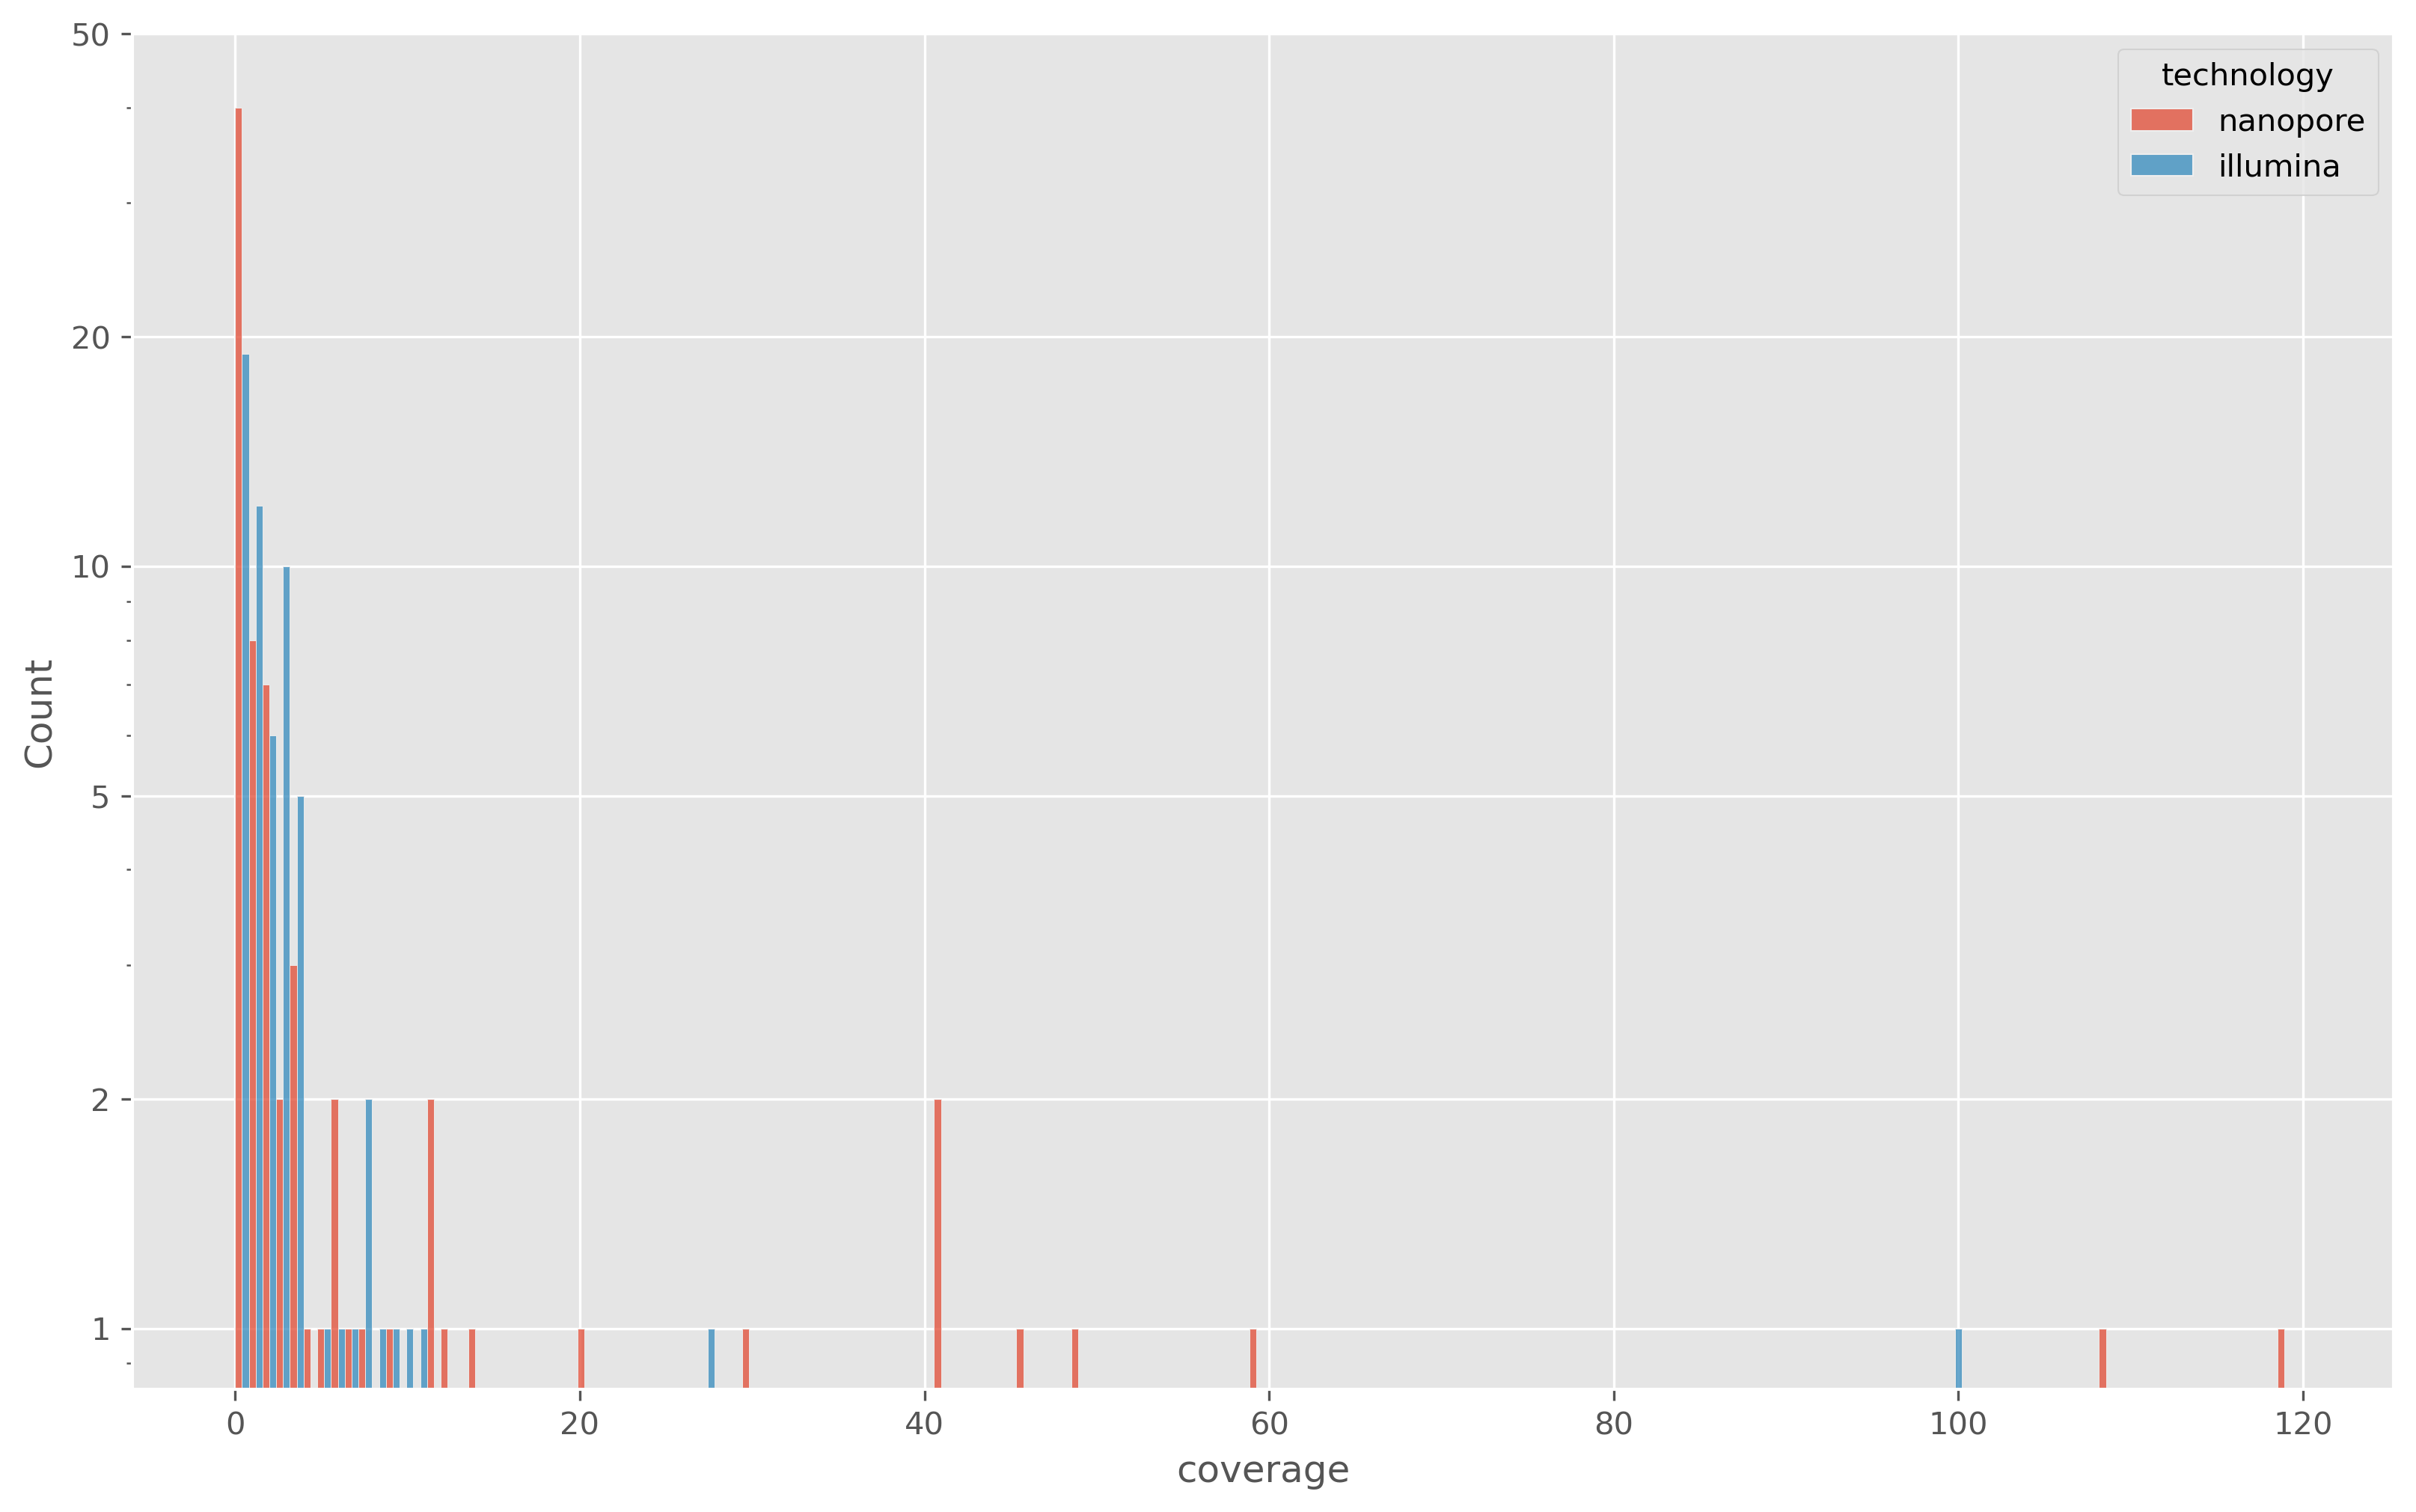

In [20]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
data = comp_df.query("source=='sputum'")
x = "coverage"
hue = "technology"
sns.histplot(data=data, x=x, hue=hue, ax=ax, multiple="dodge", bins=150)
ax.set_yscale("log")
ticks = [1, 2, 5, 10, 20, 50]
ax.set_yticks(ticks)
_ = ax.set_yticklabels(ticks)

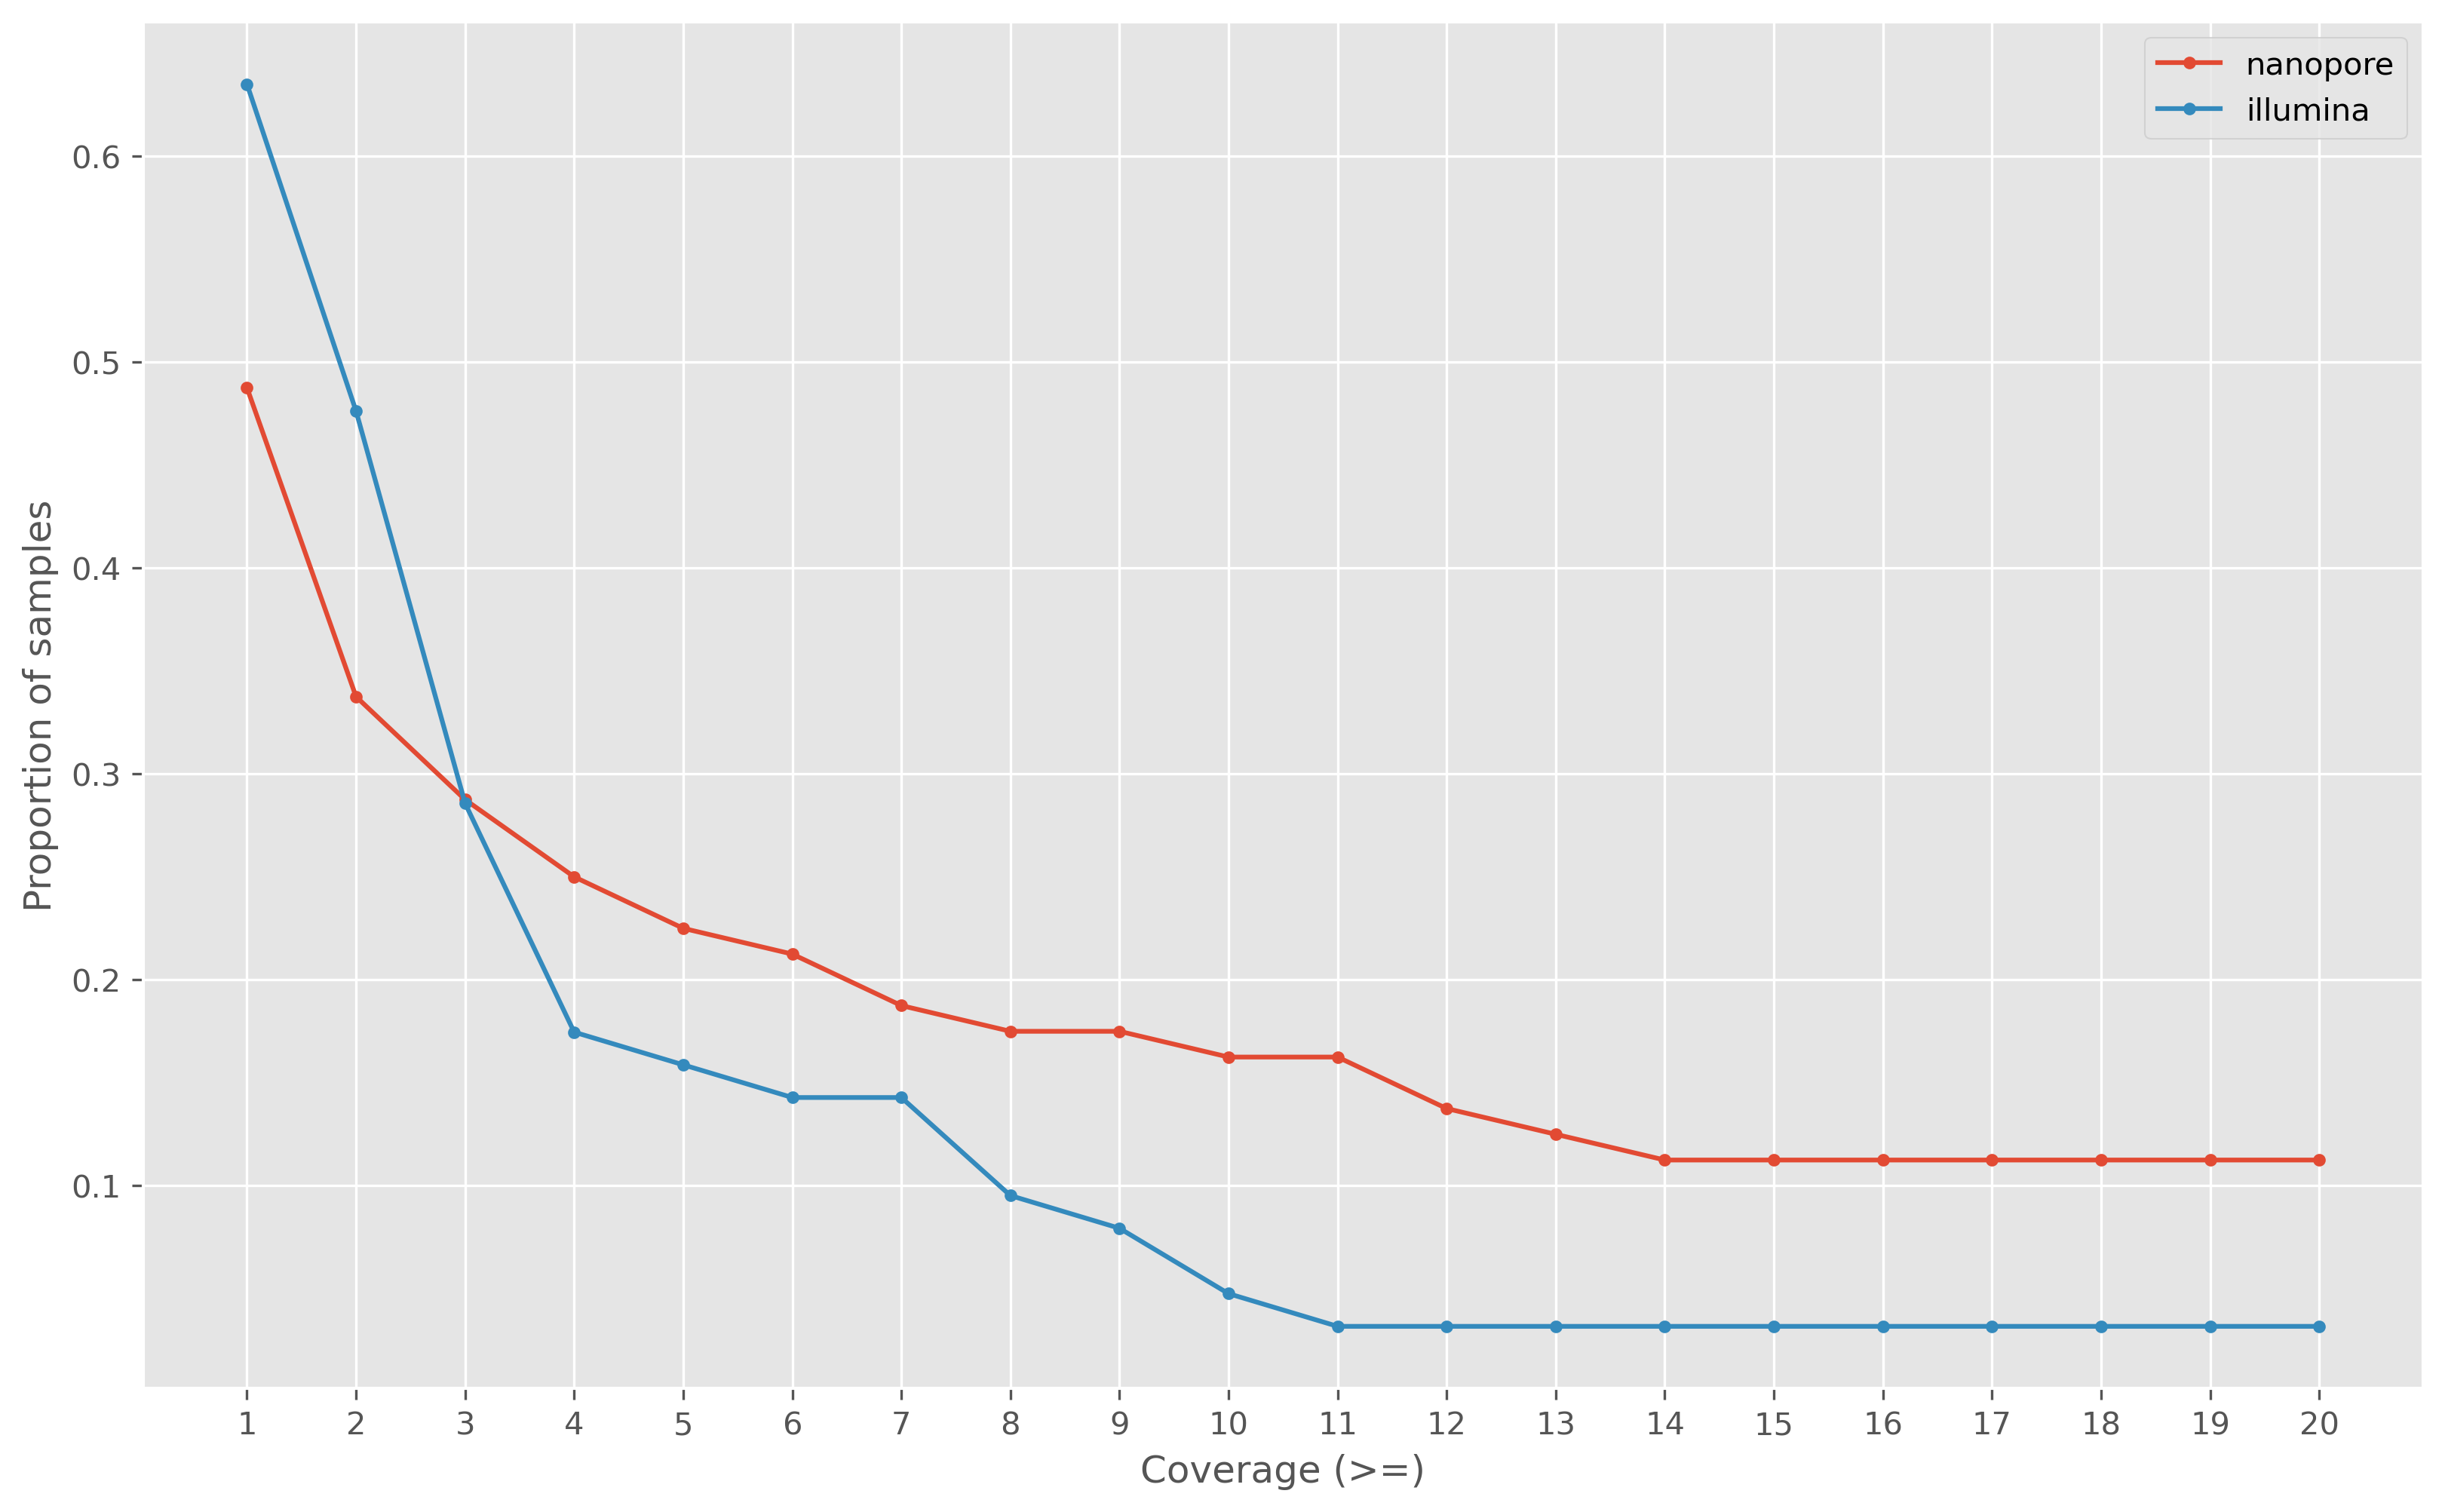

In [21]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)
ont_ys = []
ill_ys = []
for y in range(1, 21):
    d = data.query("coverage>=@y")
    q = "technology=='nanopore'"
    p = len(d.query(q)) / len(data.query(q))
    ont_ys.append(p)
    q = "technology=='illumina'"
    p = len(d.query(q)) / len(data.query(q))
    ill_ys.append(p)
    
ax.plot(range(1, 21), ont_ys, label="nanopore", marker=".")
ax.plot(range(1, 21), ill_ys, label="illumina", marker=".")
ax.legend()
ax.set(ylabel="Proportion of samples", xlabel="Coverage (>=)")
_ = ax.set_xticks(range(1, 21))

In [22]:
for y in range(2, 22, 2):
    d = data.query("coverage>=@y")
    q = "technology=='nanopore'"
    p = len(d.query(q)) / len(data.query(q))
    print(f"{p:.1%} ({len(d.query(q))}/{len(data.query(q))}) nanopore samples have coverage >= {y}")
    q = "technology=='illumina'"
    p = len(d.query(q)) / len(data.query(q))
    print(f"{p:.1%} ({len(d.query(q))}/{len(data.query(q))}) illumina samples have coverage >= {y}")

33.8% (27/80) nanopore samples have coverage >= 2
47.6% (30/63) illumina samples have coverage >= 2
25.0% (20/80) nanopore samples have coverage >= 4
17.5% (11/63) illumina samples have coverage >= 4
21.2% (17/80) nanopore samples have coverage >= 6
14.3% (9/63) illumina samples have coverage >= 6
17.5% (14/80) nanopore samples have coverage >= 8
9.5% (6/63) illumina samples have coverage >= 8
16.2% (13/80) nanopore samples have coverage >= 10
4.8% (3/63) illumina samples have coverage >= 10
13.8% (11/80) nanopore samples have coverage >= 12
3.2% (2/63) illumina samples have coverage >= 12
11.2% (9/80) nanopore samples have coverage >= 14
3.2% (2/63) illumina samples have coverage >= 14
11.2% (9/80) nanopore samples have coverage >= 16
3.2% (2/63) illumina samples have coverage >= 16
11.2% (9/80) nanopore samples have coverage >= 18
3.2% (2/63) illumina samples have coverage >= 18
11.2% (9/80) nanopore samples have coverage >= 20
3.2% (2/63) illumina samples have coverage >= 20


Let's look at read coverage by smear result

In [23]:
def legend_without_duplicate_labels(ax, title=""):
    handles, labels = ax.get_legend_handles_labels()
    labels = list(map(str.capitalize, labels))
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), title=title)

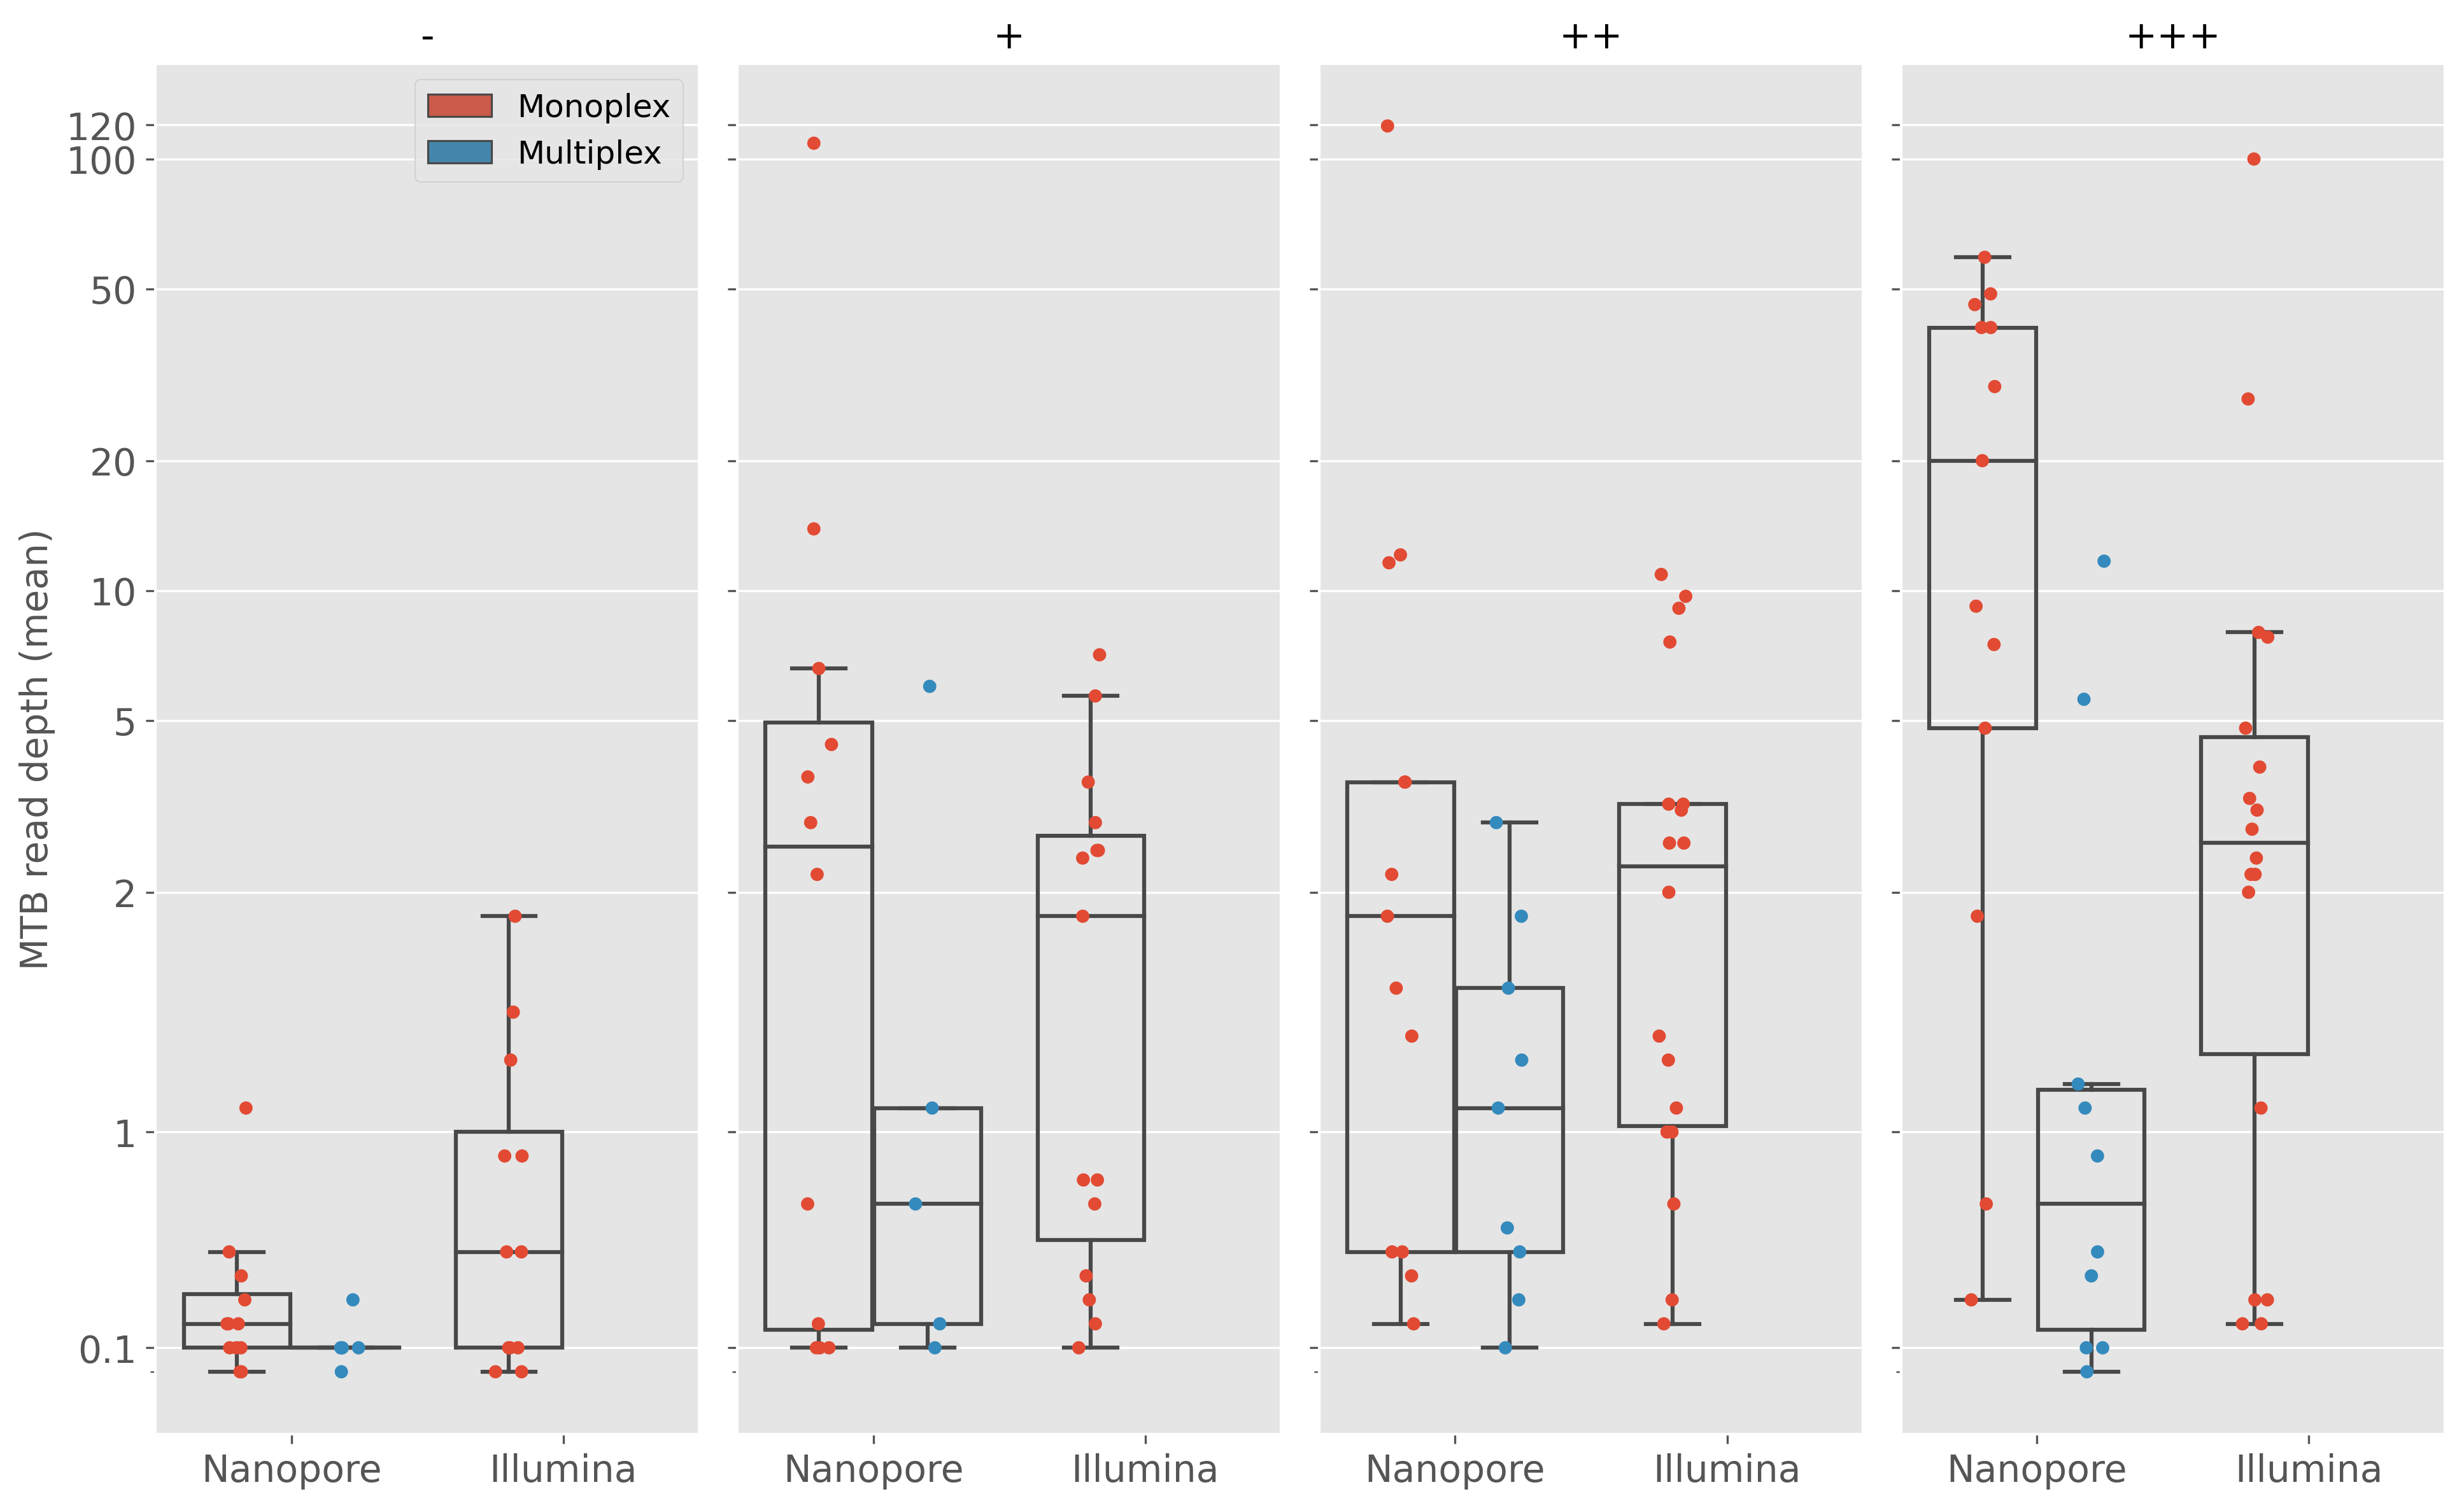

In [24]:
data = comp_df.query("source=='sputum'")
lsize = 14  # label size
x = "technology"
y = "coverage"
hue = "is_multiplex"
order = ["-", "+", "++", "+++"]
fig, axes = plt.subplots(figsize=(13, 8), dpi=300, ncols=len(order), sharey=True)
for i, (smear, ax) in enumerate(zip(order, axes.flatten())):
    sns.boxplot(data=data.query("smear==@smear"), x=x, y=y, hue=hue, ax=ax, boxprops=dict(facecolor="none"), fliersize=0)
    sns.stripplot(data=data.query("smear==@smear"), x=x, y=y, hue=hue, ax=ax, dodge=True)
    ax.set_yscale("symlog")
    ticks = [0.1, 1, 2, 5, 10, 20, 50, 100, 120]
    ax.set_yticks(ticks)
    _ = ax.set_yticklabels(ticks)
    ax.set_xlabel("")
    if i == 0:
            handles, labels = ax.get_legend_handles_labels()
            labels = ["Multiplex" if l == "True" else "Monoplex" for l in labels]
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique), fontsize="12")
    else:
        ax.legend().remove()
#     ax.set_ylim((-0.1, 150))
    ylabel = "" if i > 0 else "MTB read depth (mean)"
    _ = ax.set_ylabel(ylabel, fontsize="14")
    labels = []
    for label in ax.get_xticklabels():
        label.set_fontsize(lsize)
        label.set_text(label.get_text().capitalize())
        labels.append(label)
    ax.set_xticklabels(labels)
    ax.yaxis.set_tick_params(labelsize=lsize)
    
    ax.set_title(smear)

plt.tight_layout()

Load the krona composition data

In [25]:
def load_krona_counts(path: Path) -> Dict[str, int]:
    counter = defaultdict(int)
    with open(path) as fp:
        for row in map(str.rstrip, fp):
            count, organism = row.split("\t")[:2]
            counter[organism] += int(count)
    total_reads = sum(counter.values())
    for k, v in counter.items():
        counter[k] = v/total_reads
    return counter

In [26]:
tsvs = list(Path("../../results/").rglob("*.krona.tsv"))

In [70]:
counts = dict()
for p in tsvs:
    tech = p.parts[3]
    if tech == "illumina":
        source = p.parts[-2]
    else:
        source = "sputum"
    name = p.name.split(".")[0]
    short_name = sample_name(name)
    
    if short_name not in final_samples:
        continue
        
    if "_rep" in name:
        continue
      
    if "singleplex" in name or tech == "illumina":
        is_multi = False
    elif "multiplex" in name:
        is_multi = True
    else:
        d = comp_df.query("technology=='nanopore' and sample==@short_name")
        assert len(d) == 1, name
        is_multi = list(d["is_multiplex"])[0]
        
    is_neg = name.startswith("PCt") or name.startswith("Test_NC")
    counts[(tech, source, short_name, is_multi, is_neg)] = load_krona_counts(p)

In [71]:
counts

{('illumina',
  'sputum',
  'Test_19',
  False,
  False): defaultdict(int,
             {'NTM': 0.05690190288713911,
              'Unmapped': 0.1354957349081365,
              'Virus': 6.233595800524934e-06,
              'Bacteria': 0.6017339238845144,
              'TB': 0.0738507217847769,
              'Human': 0.13201148293963255}),
 ('illumina',
  'sputum',
  'Test_56',
  False,
  False): defaultdict(int,
             {'NTM': 0.0007553644548045964,
              'Unmapped': 0.0490321712166442,
              'Virus': 1.3145918113550233e-07,
              'Bacteria': 0.07614602170338497,
              'TB': 0.009214105464968494,
              'Human': 0.8648522057010166}),
 ('illumina',
  'sputum',
  'P213',
  False,
  False): defaultdict(int,
             {'NTM': 0.02293827505347731,
              'Unmapped': 0.23870360705385957,
              'Virus': 4.410499930167084e-05,
              'Bacteria': 0.18764104411235014,
              'TB': 0.01872992303677622,
              'Hum

In [172]:
comp_stack = pd.DataFrame(counts).T.reset_index().rename(columns={"level_0": "technology", "level_1": "source", "level_2": "name", "level_3": "is_multiplex", "level_4": "is_negative"}).fillna(0).melt(
    value_vars=["NTM", "Unmapped", "Virus", "Bacteria", "TB", "Human"], 
    id_vars=["technology", "name", "source", "is_multiplex", "is_negative"],
    var_name="Organism",
    value_name="num_reads"
)

In [173]:
comp_stack

,technology,name,source,is_multiplex,is_negative,Organism,num_reads
0,illumina,Test_19,sputum,False,False,NTM,0.056902
1,illumina,Test_56,sputum,False,False,NTM,0.000755
2,illumina,P213,sputum,False,False,NTM,0.022938
3,illumina,P207,sputum,False,False,NTM,0.070218
4,illumina,Test_38,sputum,False,False,NTM,0.000426
...,...,...,...,...,...,...,...
1117,nanopore,P216,sputum,False,False,Human,0.768806
1118,nanopore,Test_36,sputum,True,False,Human,0.976699
1119,nanopore,P222,sputum,False,False,Human,0.289922
1120,nanopore,Test_NC1,sputum,False,True,Human,0.654354


In [180]:
NA = "N/A"
cats = [("illumina", "culture", False), ("illumina", "sputum", False), ("nanopore", "sputum", False), ("nanopore", "sputum", True)]
for tech, src, is_multi in cats:
    data = comp_stack.query("technology==@tech and source==@src and is_multiplex==@is_multi")
    missing_samples = final_samples - set(data["name"])
    for s in missing_samples:
        is_neg = "NC" in s or "PCt" in s
        comp_stack.loc[-1] = [tech, s, src, is_multi, is_neg, NA, 1]
        comp_stack.index = comp_stack.index + 1  # shifting index

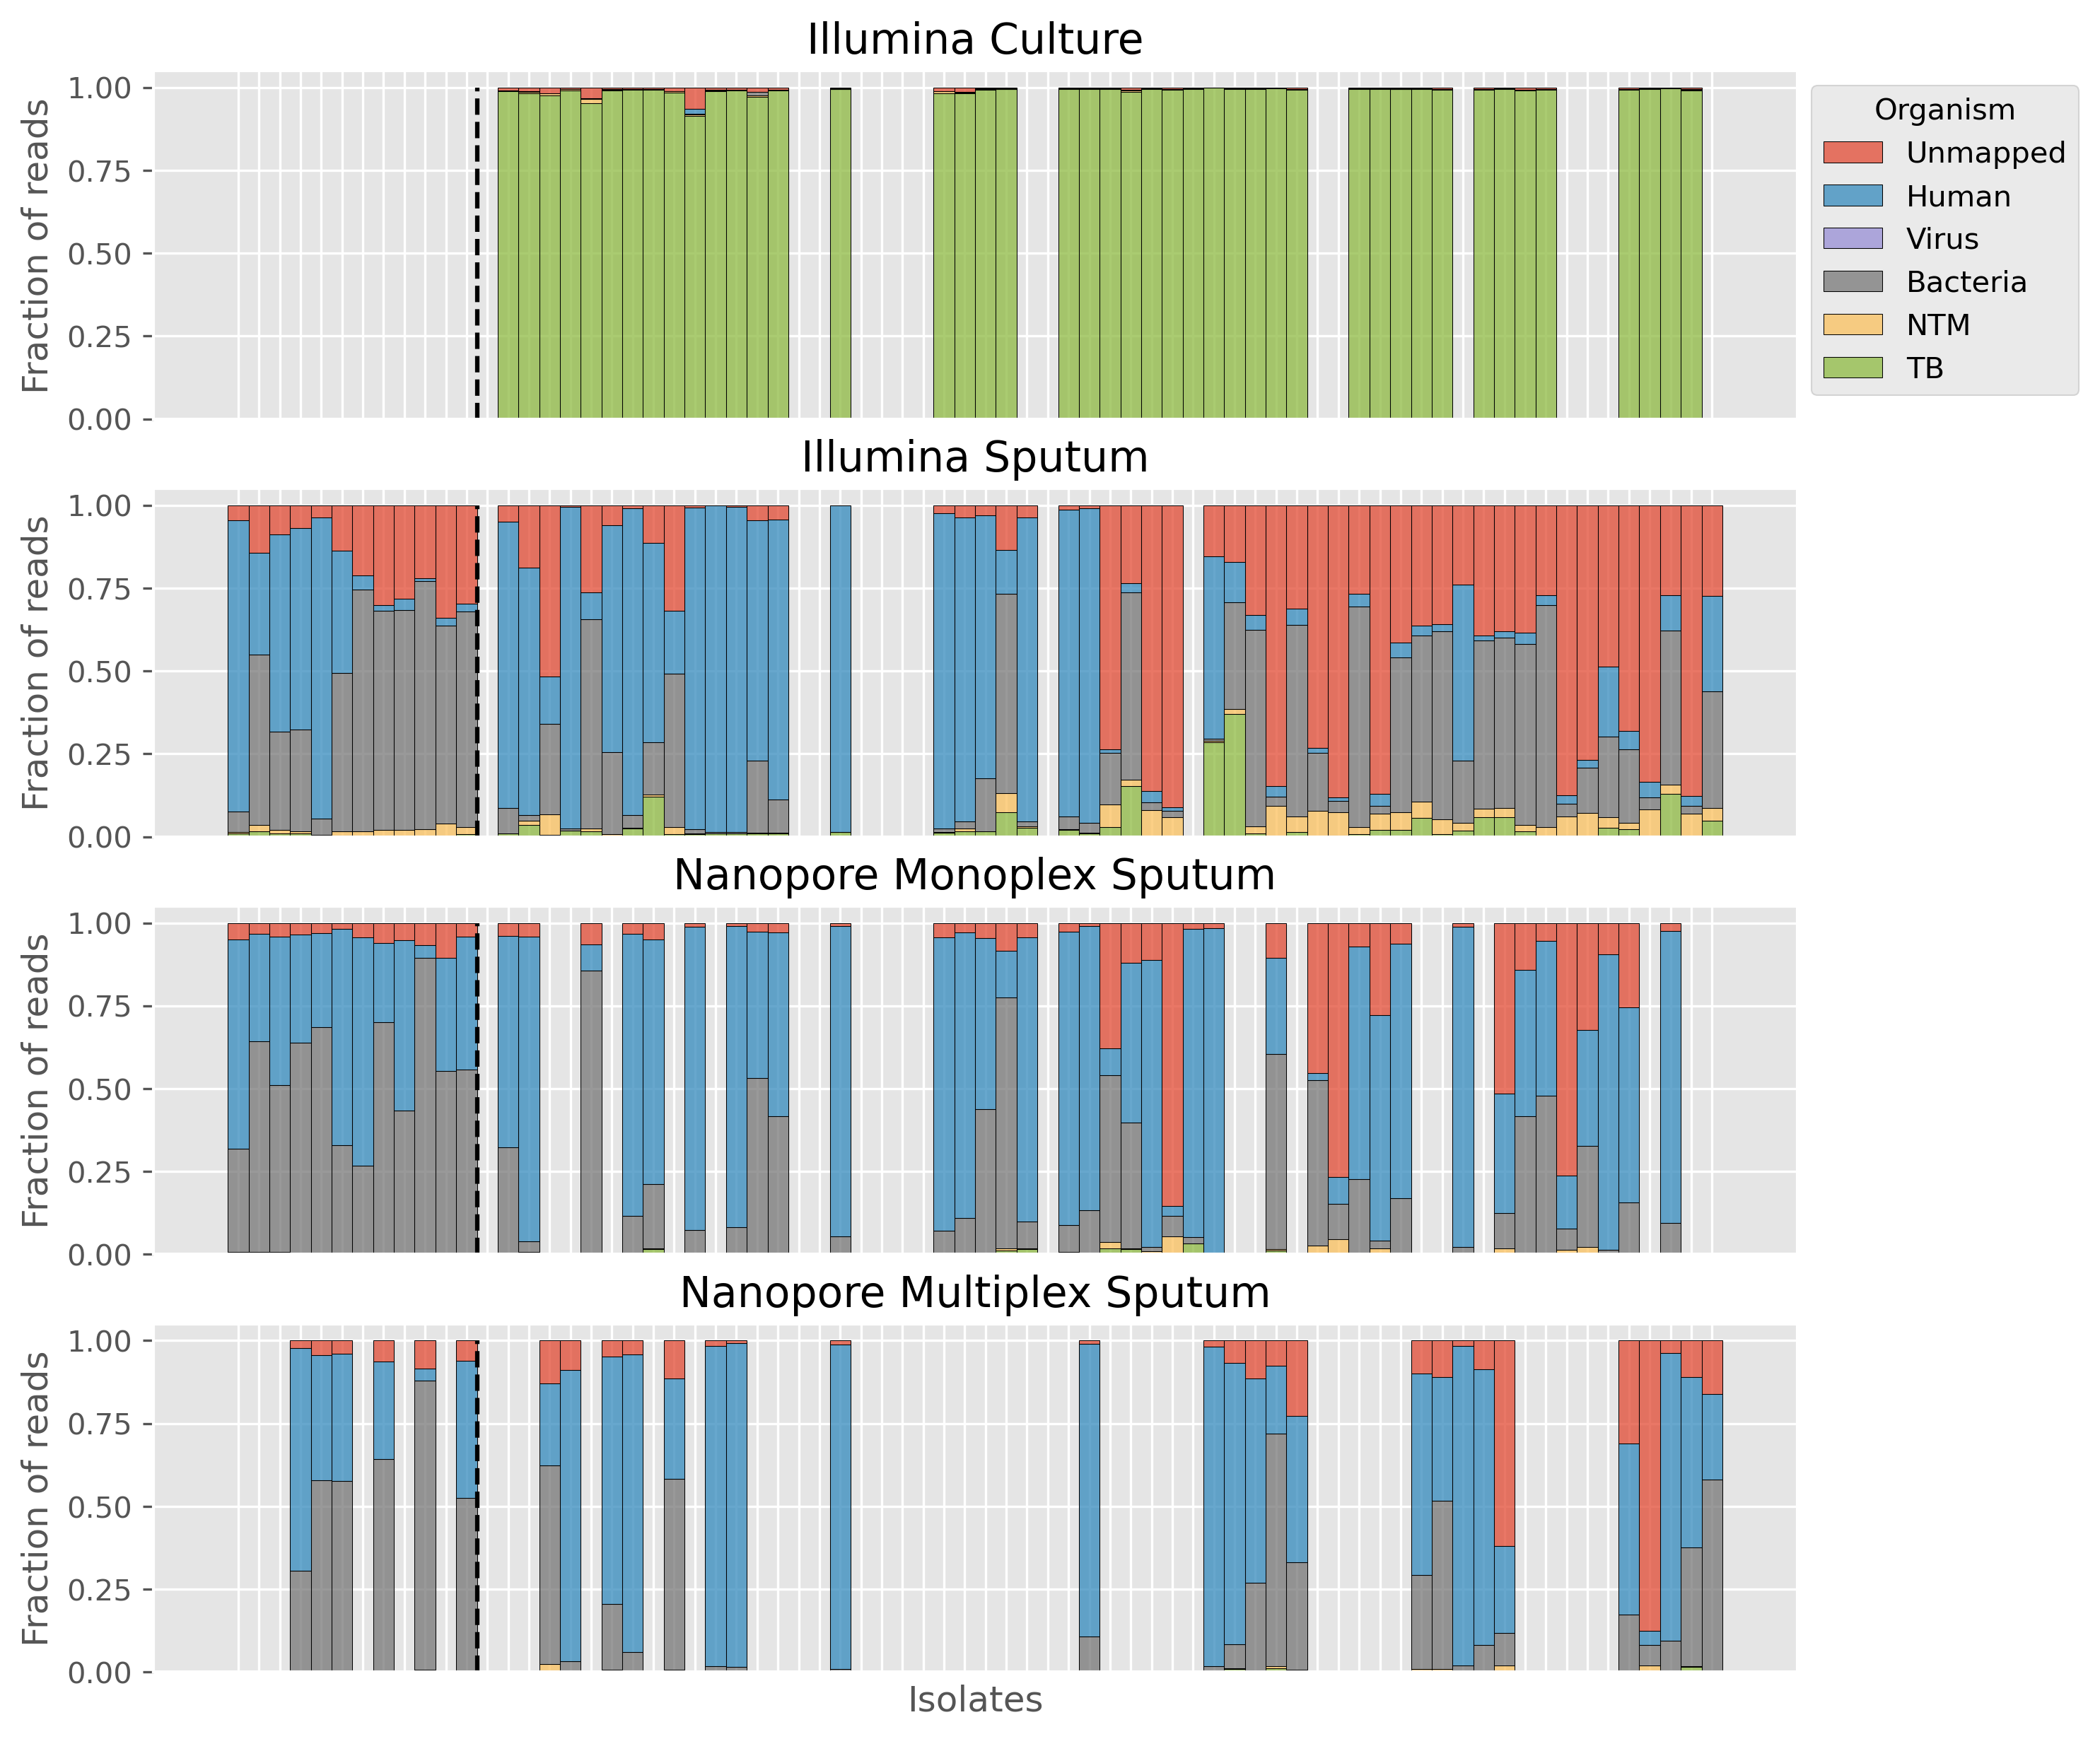

In [198]:
    
fig, axes = plt.subplots(figsize=(10, 10), dpi=300, nrows=len(cats))
palette = ggplot_cm.copy()
palette[-1] = "white"
for (tech, src, is_multi), ax in zip(cats, axes.flatten()):
    data = comp_stack.query("technology==@tech and source==@src and is_multiplex==@is_multi").sort_values(by=["is_negative", "name"], ascending=False)

    bar = sns.histplot(
        data=data,
        x='name',
        # Use the value variable here to turn histogram counts into weighted
        # values.
        weights='num_reads',
        hue='Organism',
        multiple='stack',
        palette=palette[:-1],
        # Add white borders to the bars.
        edgecolor='black',
        linewidth=0.25,
        # Shrink the bars a bit so they don't touch.
    #     shrink=0.8,
    #     stat="percent",
    #     common_norm=False
        hue_order=reversed(["TB", "NTM", "Bacteria", "Virus", "Human", "Unmapped"]),
        ax=ax
    )
    xlabel = "Isolates" if is_multi else None
    if tech == "illumina":
        title = f"{tech.capitalize()} {src.capitalize()}"
    else:
        strat = "Multiplex" if is_multi else "Monoplex"
        title = f"{tech.capitalize()} {strat} {src.capitalize()}"
    ax.set(title=title, xlabel=xlabel, ylabel="Fraction of reads")


    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    num_neg = sum(1 for n in set(data["name"]) if "NC" in n or "PCt" in n)-0.5
    if num_neg > 0:
        ax.vlines(num_neg, 0, 1, linestyle="dashed", color="black")
        
    if not src == "culture":
        ax.get_legend().remove()
    else:

#         ax.legend(hs[:-1], ls[:-1])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        hs, ls = ax.get_legend_handles_labels()

fig.savefig("fig4.png")
fig.savefig("fig4.svg")

In [201]:
comp_stack.query("Organism=='TB'").min()

technology      illumina
name                P201
source           culture
is_multiplex       False
is_negative        False
Organism              TB
num_reads       0.000016
dtype: object

Let's look at how coverage changes when multiplexed

In [31]:
singles = set()
multis = set()
data = []
for i, row in comp_df.query("technology=='nanopore'").iterrows():
    sample = row["sample"]
    name = sample_name(sample)
    multi = row["is_multiplex"]
    if multi:
        multis.add(name)
    else:
        singles.add(name)
    smear = row["smear"]
    cov = row["coverage"]
    data.append((name, multi, cov, smear))
    
both = singles.intersection(multis)
print(f"{len(both)} samples sequenced on both")
# data = [t for t in data if t[0] in both]

16 samples sequenced on both


In [32]:
multidf = pd.DataFrame(data, columns=["name", "multiplexed", "coverage", "smear"])

In [33]:
data = pd.pivot_table(multidf, values="coverage", index=["name", "multiplexed", "smear"]).reset_index()

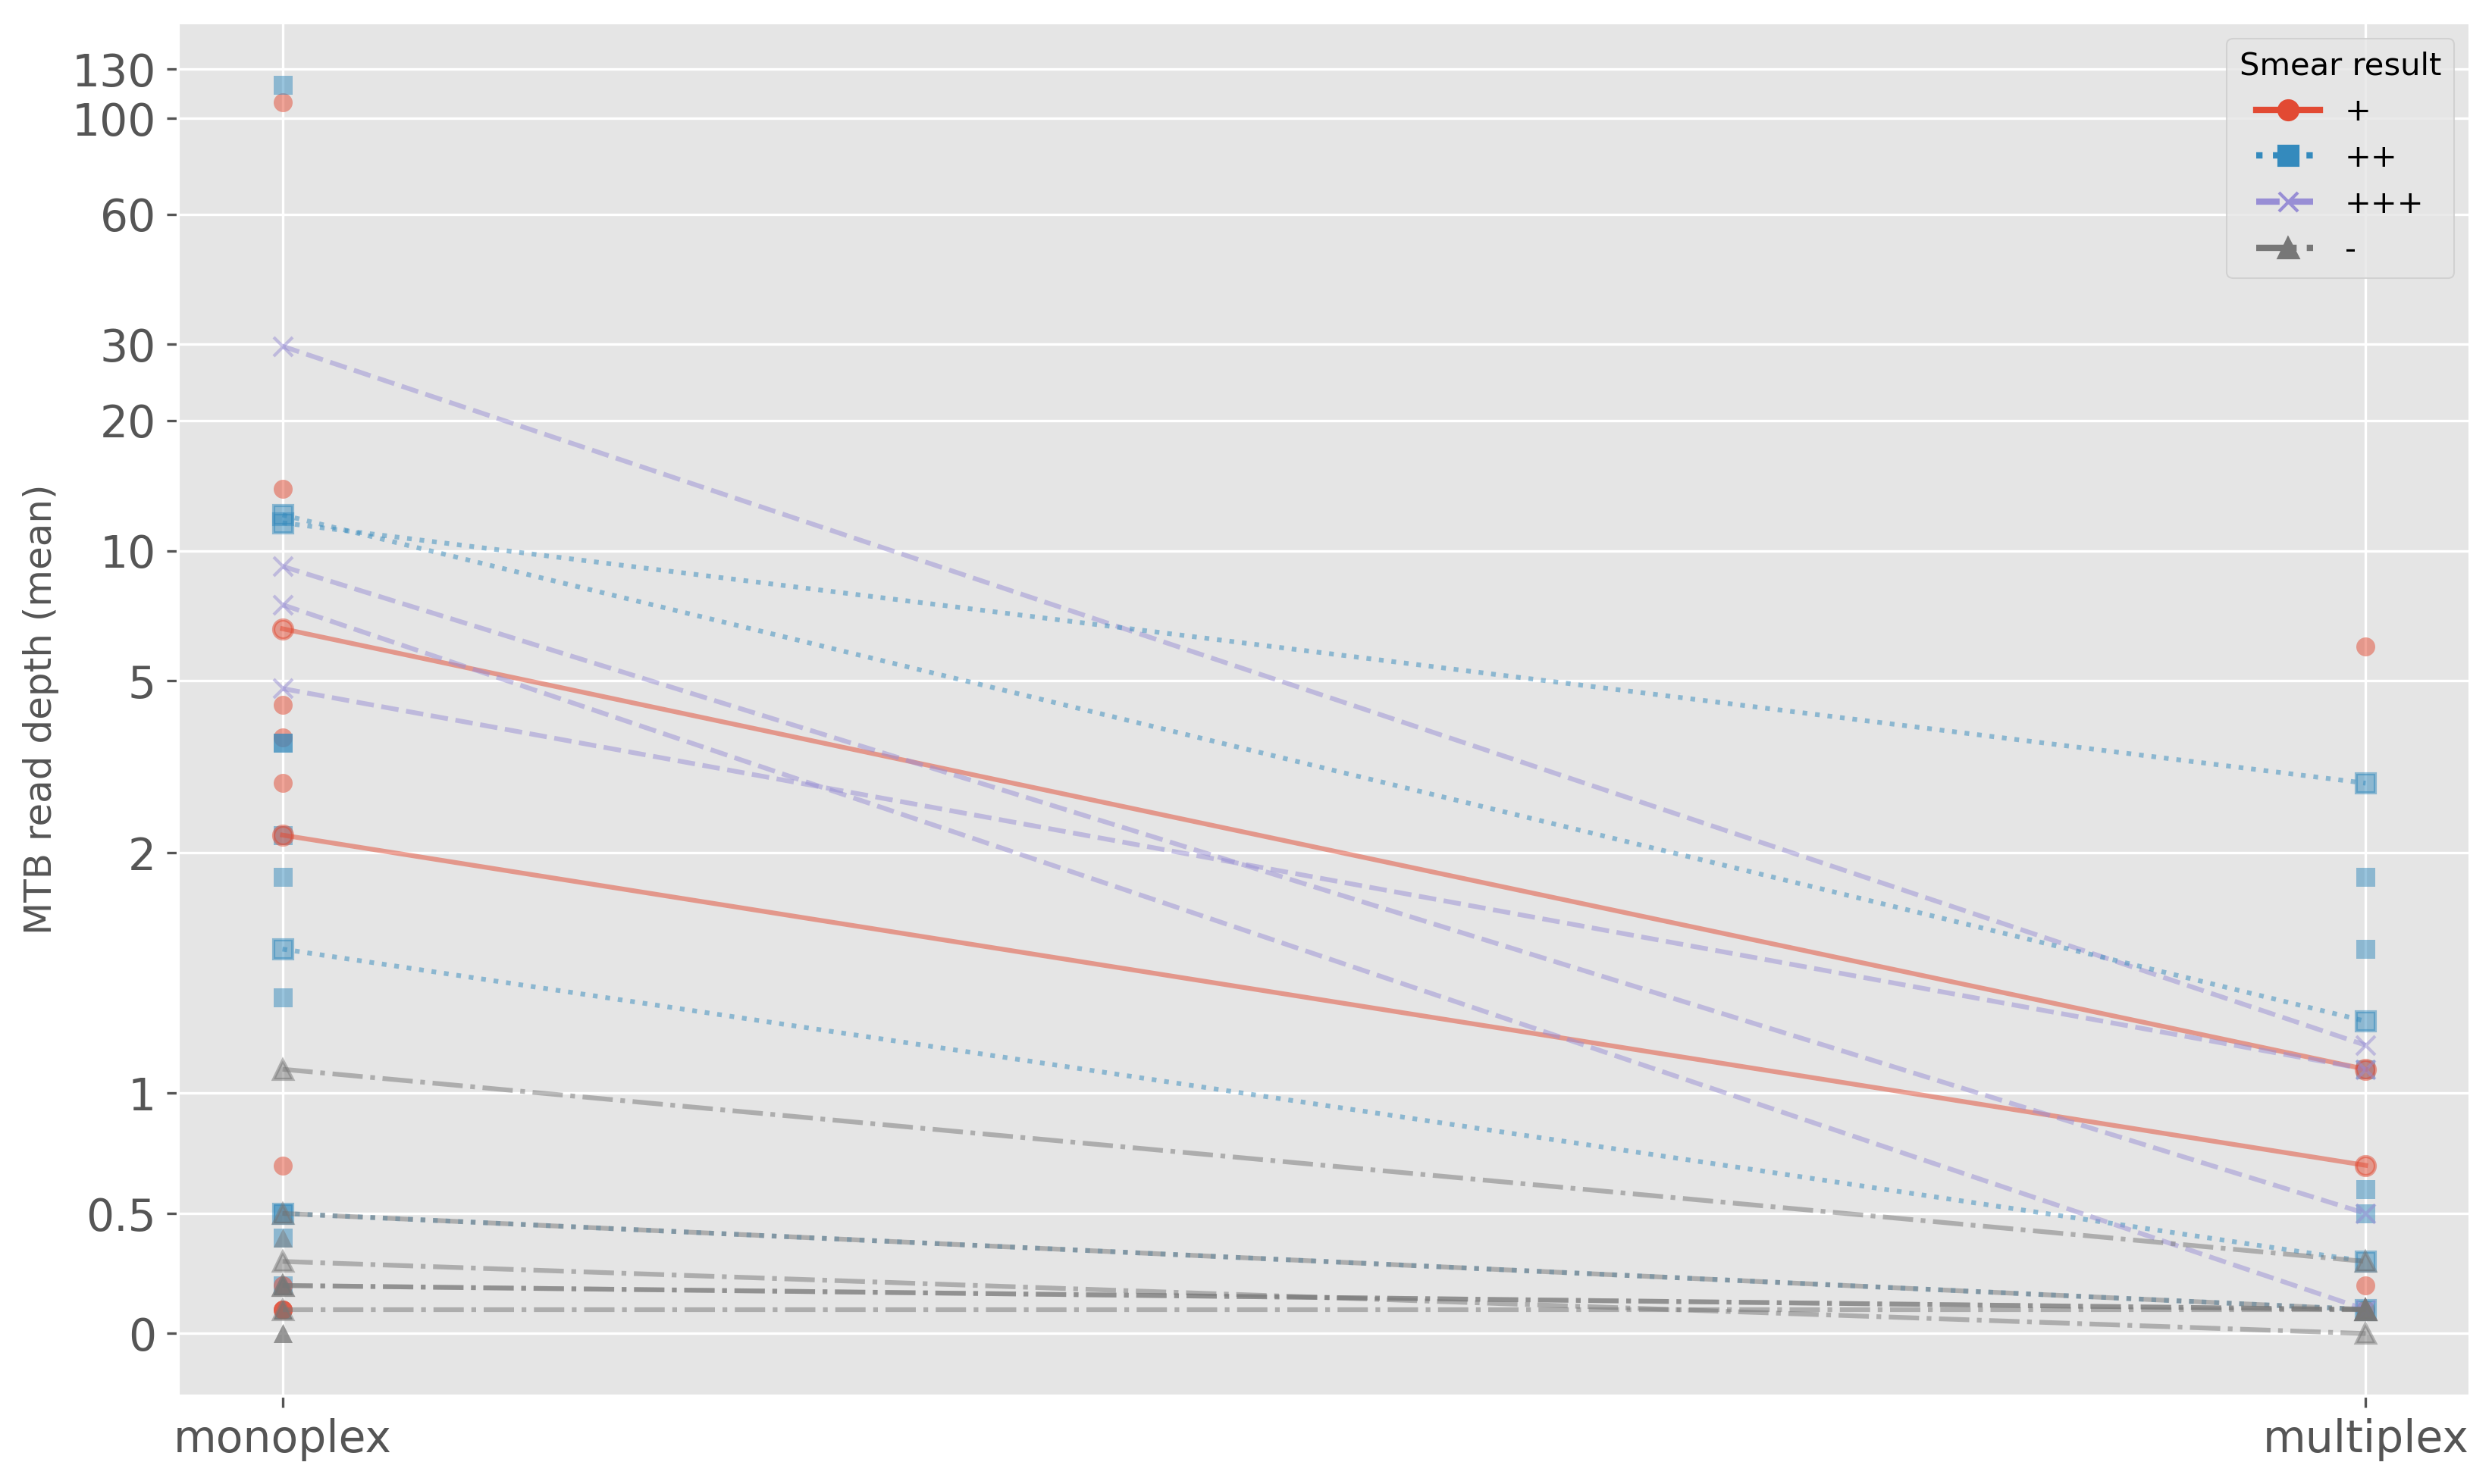

In [34]:
fig, ax = plt.subplots(figsize=(13, 8), dpi=300)


xs = []
ys = []
xs = {"monoplex": 0, "multiplex": 1}
x = "multiplexed"
y = "coverage"
smears = ["+", "++", "+++", "-"]
markers = ["o", "s", "x", "^"]
styles = ["-", ":", "--", "-."]
alpha = 0.5

single_only = singles - both
multi_only = multis - both

for _, row in data.query("name not in @both").iterrows():
    i = smears.index(row["smear"])
    colour = ggplot_cm[i]
    style = styles[i]
    marker = markers[i]
    ax.scatter(row[x], row[y], color=colour, alpha=alpha, marker=marker, lw=0)
    ax.set_yscale("symlog")
    ticks = [0, 0.5, 1, 2, 5, 10, 20, 30, 60, 100, 130]
    ax.set_yticks(ticks)
    _ = ax.set_yticklabels(ticks)  
# #     ax.set_ylim((-0.1, 140))

both_df = data.query("name in @both")
for i in range(0, len(both_df), 2):
    
    this_row = both_df.iloc[i]
    next_row = both_df.iloc[i+1]
    ix = smears.index(this_row["smear"])

    assert this_row["name"] == next_row["name"]
    colour = ggplot_cm[ix]
    style = styles[ix]
    marker = markers[ix]
    
    ax.plot([this_row[x], next_row[x]], [this_row[y], next_row[y]], color=colour, alpha=alpha, linestyle=style, marker=marker)






patches = [mlines.Line2D([], [], color=ggplot_cm[i], marker=markers[i], lw=2, ls=styles[i], label=s) for i, s in enumerate(smears)]
ax.set_xticks([0, 1])
ax.set_xticklabels(["monoplex", "multiplex"])
ax.set_ylabel("MTB read depth (mean)")
plt.legend(handles=patches, title="Smear result")
for label in (ax.get_xticklabels() + ax.get_xticklabels()):
    label.set_fontsize(lsize)
ax.yaxis.set_tick_params(labelsize=lsize)

Summary tables

In [35]:
comp_df.query("source=='sputum'").groupby(["smear", "technology", "is_multiplex"])["coverage"].describe()[["count", "50%", "min", "max"]]

count    50%  min    max
smear technology is_multiplex                          
+     illumina   False          15.0   1.90  0.1    7.1
      nanopore   False          12.0   2.55  0.1  108.8
                 True            5.0   0.70  0.1    6.0
++    illumina   False          18.0   2.30  0.2   10.9
      nanopore   False          13.0   1.90  0.2  119.3
                 True            9.0   1.10  0.1    2.9
+++   illumina   False          18.0   2.60  0.2  100.0
      nanopore   False          13.0  20.00  0.3   59.2
                 True           10.0   0.70  0.0   11.7
-     illumina   False          12.0   0.50  0.0    1.9
      nanopore   False          12.0   0.20  0.0    1.1
                 True            6.0   0.10  0.0    0.3

In [36]:
ont_df

,run,barcode,barcode_kit
sample,,,
P201,P201-P205,NB01,EXP-NBD104
P202,P201-P205,NB02,EXP-NBD104
P203-multiplex,P201-P205,NB03,EXP-NBD104
P203-singleplex,P203,NaN,NaN
P204,P201-P205,NB04,EXP-NBD104
...,...,...,...
Test_NC3-singleplex,Test_NC3,NaN,NaN
Test_NC3-multiplex,Multi_1Plus_sputum,NB06,EXP-NBD104
Test_NC4,Test_NC4,NaN,NaN


In [37]:
nanoq_tsvs = Path("../../results/nanopore/summary/").rglob("*.tsv")
dfs = []
for p in nanoq_tsvs:
    sample = p.name.split(".")[0]
    is_multi = not pd.isna(ont_df.at[sample, "barcode_kit"])
    name = sample_name(sample)
    
    if name not in final_samples:
        continue
    
    frame = pd.read_csv(p, sep=" ")
    frame["sample"] = sample
    frame["is_multiplex"] = is_multi
    smears = list(set(comp_df.query("sample==@name")["smear"]))
    assert len(smears) == 1, p
    frame["smear"] = smears[0]
    frame["technology"] = "nanopore"
    dfs.append(frame)
nanoq_df = pd.concat(dfs)
nanoq_df

,reads,bases,n50,longest,shortest,mean_length,median_length,mean_quality,median_quality,sample,is_multiplex,smear,technology
0,8327,9531509,1805,9449,110,1144,767,13.2,13.0,P219,False,++,nanopore
0,7710,21012223,3938,14115,179,2725,2322,14.3,14.4,Test_36-singleplex,False,+++,nanopore
0,2376,7025375,4538,14220,81,2956,2526,15.2,15.5,Test_48,True,++,nanopore
0,269,665875,4028,9436,213,2475,1877,13.7,13.9,Test_32,False,+,nanopore
0,67,106093,3442,7960,166,1583,583,13.4,13.3,PCtrl-4,False,-,nanopore
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3867,8149217,3485,18620,86,2107,1635,15.3,15.4,Test_40,True,++,nanopore
0,114,204774,2662,5366,119,1796,1592,13.1,12.7,PCtrl-1-multiplex,True,-,nanopore
0,199920,261246021,1780,12685,112,1306,1104,13.9,13.9,P230,False,+++,nanopore
0,3801,4182133,1704,6962,53,1100,776,14.3,14.3,P224,True,+++,nanopore


In [38]:
data = comp_df
for smear in ["+", "++", "+++"]:
    print(smear)
    for tech in ["illumina", "nanopore"]:
        print(tech)
        for is_multi in [False, True]:
            for y in [1, 5, 20]:
                qry = "technology==@tech and smear==@smear and is_multiplex==@is_multi"
                d_total = data.query(qry)
                if d_total.empty:
                    continue
                else:
                    print(is_multi)
                d = d_total.query("coverage>=@y")
                p = len(d) / len(d_total)
                print(f"{p:.1%} ({len(d)}/{len(d_total)}) samples have coverage >= {y}")

+
illumina
False
73.1% (19/26) samples have coverage >= 1
False
50.0% (13/26) samples have coverage >= 5
False
42.3% (11/26) samples have coverage >= 20
nanopore
False
58.3% (7/12) samples have coverage >= 1
False
25.0% (3/12) samples have coverage >= 5
False
8.3% (1/12) samples have coverage >= 20
True
40.0% (2/5) samples have coverage >= 1
True
20.0% (1/5) samples have coverage >= 5
True
0.0% (0/5) samples have coverage >= 20
++
illumina
False
90.9% (30/33) samples have coverage >= 1
False
57.6% (19/33) samples have coverage >= 5
False
45.5% (15/33) samples have coverage >= 20
nanopore
False
69.2% (9/13) samples have coverage >= 1
False
23.1% (3/13) samples have coverage >= 5
False
7.7% (1/13) samples have coverage >= 20
True
55.6% (5/9) samples have coverage >= 1
True
0.0% (0/9) samples have coverage >= 5
True
0.0% (0/9) samples have coverage >= 20
+++
illumina
False
88.9% (32/36) samples have coverage >= 1
False
61.1% (22/36) samples have coverage >= 5
False
55.6% (20/36) samples h

In [39]:
illumina_read_length = 150

Remove culture isolates, negative smear, and replicates

In [40]:
summary = comp_df.query("source=='sputum' and smear!='-'")

In [41]:
summary = summary.loc[~summary["sample"].str.contains("_rep")]

In [42]:
summary.set_index(["sample", "technology", "is_multiplex"], inplace=True, verify_integrity=True)

In [43]:
nanoq_df

,reads,bases,n50,longest,shortest,mean_length,median_length,mean_quality,median_quality,sample,is_multiplex,smear,technology
0,8327,9531509,1805,9449,110,1144,767,13.2,13.0,P219,False,++,nanopore
0,7710,21012223,3938,14115,179,2725,2322,14.3,14.4,Test_36-singleplex,False,+++,nanopore
0,2376,7025375,4538,14220,81,2956,2526,15.2,15.5,Test_48,True,++,nanopore
0,269,665875,4028,9436,213,2475,1877,13.7,13.9,Test_32,False,+,nanopore
0,67,106093,3442,7960,166,1583,583,13.4,13.3,PCtrl-4,False,-,nanopore
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3867,8149217,3485,18620,86,2107,1635,15.3,15.4,Test_40,True,++,nanopore
0,114,204774,2662,5366,119,1796,1592,13.1,12.7,PCtrl-1-multiplex,True,-,nanopore
0,199920,261246021,1780,12685,112,1306,1104,13.9,13.9,P230,False,+++,nanopore
0,3801,4182133,1704,6962,53,1100,776,14.3,14.3,P224,True,+++,nanopore


Add read length

In [44]:
for i, row in nanoq_df.iterrows():
    sample = sample_name(row["sample"])
    is_multi = row["is_multiplex"]
    if summary.query("sample==@sample").empty:
        continue
    try:
        summary.at[(sample, "nanopore", is_multi), "length"] = row["median_length"]
    except KeyError:
        continue

/usr/local/Caskroom/miniconda/base/envs/basecall-tb-sputum/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3106: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [45]:
summary.fillna(illumina_read_length, inplace=True)

In [46]:
summary

index   keep  keep%   contam contam%  \
sample  technology is_multiplex                                         
P201    nanopore   True              0    895  0.11%   644877  77.08%   
P202    nanopore   True              1  24865  1.83%  1153816  85.11%   
P203    nanopore   True              2   3768  0.46%   783301  95.23%   
                   False             3  19938  0.45%  4257677  96.47%   
P204    nanopore   True              4    414  0.07%    57693  10.05%   
...                                ...    ...    ...      ...     ...   
Test_46 illumina   False            72  47976  1.66%  2273614  78.86%   
Test_47 illumina   False            73  29716  1.78%  1632569  97.79%   
Test_48 illumina   False            74  15190  0.58%  1342983  50.99%   
Test_51 illumina   False            76  58168  3.59%  1267303  78.20%   
Test_56 illumina   False            81  35856  0.94%  3620359  95.19%   

                                 unmapped unmapped%    total  coverage  \
sample  technology is_multiplex                                          
P201    nanopore   True            190847    22.81%   836619       0.2   
P202    nanopore   True            176981    13.05%  1355662       6.0   
P203    nanopore   True             35497     4.32%   822566       1.1   
                   False           136039     3.08%  4413654       6.6   
P204    nanopore   True            515903    89.88%   574010       0.1   
...                                   ...       ...      ...       ...   
Test_46 illumina   False           561599    19.48%  2883189       3.2   
Test_47 illumina   False             7177     0.43%  1669462       2.0   
Test_48 illumina   False          1275602    48.43%  2633775       1.0   
Test_51 illumina   False           295058    18.21%  1620529       3.9   
Test_56 illumina   False           147247     3.87%  3803462       2.4   

                                 lineage                     species  source  \
sample  technology is_multiplex                                                
P201    nanopore   True          Unknown  Mycobacterium_tuberculosis  sputum   
P202    nanopore   True            1.1.2  Mycobacterium_tuberculosis  sputum   
P203    nanopore   True          Unknown  Mycobacterium_tuberculosis  sputum   
                   False           4.1.2  Mycobacterium_tuberculosis  sputum   
P204    nanopore   True          Unknown                     Unknown  sputum   
...                                  ...                         ...     ...   
Test_46 illumina   False         Unknown  Mycobacterium_tuberculosis  sputum   
Test_47 illumina   False         4.3.4.1  Mycobacterium_tuberculosis  sputum   
Test_48 illumina   False               3  Mycobacterium_tuberculosis  sputum   
Test_51 illumina   False           2.2.3  Mycobacterium_tuberculosis  sputum   
Test_56 illumina   False         Unknown  Mycobacterium_tuberculosis  sputum   

                                smear  length  
sample  technology is_multiplex                
P201    nanopore   True             +   947.0  
P202    nanopore   True             +   853.0  
P203    nanopore   True             +  1035.0  
                   False            +  1193.0  
P204    nanopore   True             +  1313.0  
...                               ...     ...  
Test_46 illumina   False           ++   150.0  
Test_47 illumina   False          +++   150.0  
Test_48 illumina   False           ++   150.0  
Test_51 illumina   False          +++   150.0  
Test_56 illumina   False          +++   150.0  

[113 rows x 14 columns]

Write pandas table to Word document: https://stackoverflow.com/a/40597684/5299417

In [47]:
import docx
from itertools import product

In [48]:
smears = ["+", "++", "+++"]
tech = ["illumina", "nanopore"]
multi = [False, True]
rows = defaultdict(str)
delim = "\t"
headers = [delim, f"Smear positivity{delim}"]
combinations = [("illumina", "+", False), 
                ("illumina", "++", False), 
                ("illumina", "+++", False), 
                ("nanopore", "+", False), 
                ("nanopore", "++", False), 
                ("nanopore", "+++", False), 
                ("nanopore", "+", True), 
                ("nanopore", "++", True), 
                ("nanopore", "+++", True)]
for t, s, m in combinations:
    if (t, m) == ("illumina", True):
        continue
    tech_df = summary.query("technology==@t and is_multiplex==@m")
    if s == '+':
        if t == "nanopore":
            strategy = " multiplex" if m else " monoplex"
        else:
            strategy = ""
        headers[0] += f"{t.capitalize()}{strategy} (n={len(tech_df)}){delim*3}"
    smear_df = tech_df.query("smear==@s")
    headers[1] += f"{s.count('+')}+ (n={len(smear_df)}){delim}"
    # total sequenced reads
    totals = smear_df["total"]
    rows["Total reads [median (range)]"] += f"{delim}{int(totals.median()):,d} ({int(totals.min()):,d}-{int(totals.max()):,d})"
    # read length
    if t == "illumina":
        rows["Read length [median (range)]"] += f"{delim}{illumina_read_length}"
    else:
        subdf = nanoq_df.query("is_multiplex==@m and smear==@s")
        lens = subdf["median_length"]
        rows["Read length [median (range)]"] += f"{delim}{int(lens.median()):,d} ({int(lens.min()):,d}-{int(lens.max()):,d})"
    # contamination reads
    contam = smear_df["contam"]
    rows["Contamination reads [median (range)]"] += f"{delim}{int(contam.median()):,d} ({int(contam.min()):,d}-{int(contam.max()):,d})"
    # mtbc reads
    keep = smear_df["keep"]
    rows["MTB reads [median (range)]"] += f"{delim}{int(keep.median()):,d} ({int(keep.min()):,d}-{int(keep.max()):,d})"
    # average depth
    covg = smear_df["coverage"]
    rows["Coverage [median (range)]"] += f"{delim}{round(covg.median(), 1)} ({covg.min()}-{covg.max()})"
    
for y in [1, 5, 20]:
    for t, s, m in combinations:
        tech_df = summary.query("technology==@t and is_multiplex==@m")
        smear_df = tech_df.query("smear==@s")
        if (t, m) == ("illumina", True):
            continue

        covdf = smear_df.query("coverage>=@y")
        p = len(covdf) / len(smear_df)
        rows[f"≥{y}X coverage"] += f"{delim}{len(covdf)} ({p:.0%})"

In [49]:
for k in rows:
    print(k)

Total reads [median (range)]
Read length [median (range)]
Contamination reads [median (range)]
MTB reads [median (range)]
Coverage [median (range)]
≥1X coverage
≥5X coverage
≥20X coverage


In [50]:
with open("composition_summary.tsv", "w") as fp:
    for l in headers:
        print(l, file=fp)
    for k, row in rows.items():
        print(f"{k}{row}", file=fp)

In [51]:
14.6/2.8

5.214285714285714

In [52]:
comp_df.query("smear=='-' and coverage > 1")

,index,sample,keep,keep%,contam,contam%,unmapped,unmapped%,total,coverage,lineage,species,source,technology,smear,is_multiplex
84,84,Test_NC2,1217,0.01%,7766595,93.18%,567245,6.81%,8335057,1.1,Unknown,Unknown,sputum,nanopore,-,False
231,86,Test_NC3,22874,1.04%,2080051,94.85%,89957,4.10%,2192882,1.5,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False
233,88,Test_NC5,28061,1.61%,1554571,88.97%,164633,9.42%,1747265,1.9,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False
234,89,Test_NC6,19959,1.00%,1900231,95.32%,73272,3.68%,1993462,1.3,Unknown,Mycobacterium_tuberculosis,sputum,illumina,-,False
